In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel("Tweet_Analysis.xlsx")

In [ ]:
df.count()

In [ ]:
df.head(10)

In [ ]:
df = df.rename(columns={"tweet_data":"twitts"})
print(df.columns.tolist())
df.head(3)

In [ ]:
df['word_count'] = df['twitts'].apply(lambda x: len(str(x).split()))
max_row = df[df['word_count'] == df['word_count'].max()]
print(max_row[['twitts', 'word_count']])


In [ ]:
!pip install emoji

In [ ]:
!pip install language-tool-python

In [ ]:
!pip install datasketch

In [ ]:
!sudo apt-get update
!sudo apt-get install openjdk-17-jdk -y
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-17-openjdk-amd64/bin/java 1
!update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!java -version

In [ ]:
!pip install symspellpy

In [ ]:
!pip install langdetect


In [ ]:
import re
import emoji
def clean_texts_twitt(text):
    cleantext = emoji.replace_emoji(text, replace='')
    cleantext = re.sub(r'http\S+\s', ' ', text)
    cleantext = re.sub(r'@\S+', ' ', cleantext)
    cleantext = re.sub(r'#\S+', ' ', cleantext)
    cleantext = re.sub(r'@\S+', ' ', cleantext)
    cleantext = re.sub(r'[%s]' % re.escape(r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleantext)
    cleantext = re.sub(r'[0-9]+', ' ', cleantext)
    cleantext = re.sub(r'[^\x00-\x7f]', r' ', cleantext)
    cleantext = re.sub(r'\s+', ' ', cleantext)
    return cleantext


In [ ]:
tweet = """@joannereid48 #ebnjc It's a very under-researched area, and there's some debate over whether it's appropriate to subject art to the rigour of science. But there's some evidence that it can improve depression and anxiety in patients with mental health issues."""
print(clean_texts_twitt(tweet))


In [ ]:
df["twitts"]= df["twitts"].apply(lambda x: clean_texts_twitt(x))

In [ ]:
#filtering explicit text pattern-------------------------------------------
import re
explicit_patterns = [
    r"\b(i|me|my|myself)\b",
    r"\bi (am|was|have|had|feel|think|know|need|want|wish|don't|did|can't|could|would|should|might)\b.*",
    r"\bi['’`]?m\b.*",
    r"\bi['’`]?ve\b.*",
    r"\bi['’`]?d\b.*",
    r"\bi['’`]?ll\b.*",
    r"\b(am|was|do|did|can|could|would|should|might) i\b.*",
]

def normalize_apostrophes(text):
    return text.replace("’", "'").replace("‘", "'").replace("`", "'")

def is_self_referential(text):
    text = normalize_apostrophes(text.lower())
    return any(re.search(pattern, text) for pattern in explicit_patterns)

explicit_texts = [t for t in df["twitts"] if is_self_referential(t)]
print(f"Number of explicit tweets: {len(explicit_texts)}")

In [ ]:
import re
import string
import nltk
import emoji
import spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from datasketch import MinHash, MinHashLSH
from langdetect import detect
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
from symspellpy import SymSpell, Verbosity
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---------------------- Setup ----------------------
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # faster

self_pronouns = {
    "i", "me", "my", "mine", "myself",
    "i'm", "i’ve", "im", "ive",
    "i’ll", "i’d", "we", "us", "our", "ours", "ourselves"
}

# ---------------------- SymSpell Setup ----------------------
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
dictionary_path = "frequency_dictionary_en_82_765.txt"  # download from SymSpell repo
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_text_symspell(text):
    corrected_tokens = []
    for word in text.split():
        if word not in stop_words:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            corrected_tokens.append(suggestions[0].term if suggestions else word)
        else:
            corrected_tokens.append(word)
    return " ".join(corrected_tokens)

# ---------------------- Utilities ----------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"http\S+|@\S+|#\S+", " ", text)
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(filtered_tokens)

def generate_ngrams(text, n_values=[1, 2, 3]):
    tokens = text.split()
    ngrams_set = set()
    for n in n_values:
        if len(tokens) >= n:
            ngrams_set |= set(" ".join(ng) for ng in ngrams(tokens, n))
    return ngrams_set

def create_minhash(shingles, num_perm=64):
    m = MinHash(num_perm=num_perm)
    for shingle in shingles:
        m.update(shingle.encode("utf8"))
    return m

# ---------------------- Explicit Detection ----------------------
def find_explicit_tweets(tweets):
    explicit_patterns = [
        r"\b(i|me|my|myself)\b",
        r"\bi (am|was|have|had|feel|think|know|need|want|wish|don't|did|can't|could|would|should|might)\b.*",
        r"\bi['’`]?m\b.*",
        r"\bi['’`]?ve\b.*",
        r"\bi['’`]?d\b.*",
        r"\bi['’`]?ll\b.*",
        r"\b(am|was|do|did|can|could|would|should|might) i\b.*",
    ]
    return [t for t in tweets if any(re.search(p, t.lower()) for p in explicit_patterns)]

# ---------------------- Clustering ----------------------
def cluster_tweets(tweets, threshold=0.15, num_perm=64):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    idx_to_tweet = {}
    for idx, tweet in enumerate(tweets):
        shingles = generate_ngrams(clean_text(tweet))
        if shingles:
            m = create_minhash(shingles, num_perm)
            lsh.insert(f"t{idx}", m)
            idx_to_tweet[f"t{idx}"] = tweet

    clusters, seen = [], set()
    for key in idx_to_tweet:
        if key not in seen:
            m = create_minhash(generate_ngrams(clean_text(idx_to_tweet[key])), num_perm)
            similar_keys = lsh.query(m)
            cluster = [idx_to_tweet[k] for k in similar_keys]
            clusters.append(cluster)
            seen.update(similar_keys)
    return clusters

# ---------------------- Merge Clusters ----------------------
def merge_similar_clusters(clusters, embeddings, sim_threshold=0.85):
    merged_clusters, merged_indices = [], set()
    for i, cluster in enumerate(clusters):
        if i in merged_indices:
            continue
        merged = cluster.copy()
        for j in range(i + 1, len(clusters)):
            if j not in merged_indices and cosine_similarity([embeddings[i]], [embeddings[j]])[0][0] > sim_threshold:
                merged.extend(clusters[j])
                merged_indices.add(j)
        merged_clusters.append(list(set(merged)))
    return merged_clusters

# ---------------------- Implicit Detection ----------------------
def find_implicit_tweets(all_tweets, explicit_clusters, explicit_tweets_set,
                          jaccard_threshold=0.02, semantic_threshold=0.50,
                          weight_jaccard=0.25, weight_semantic=0.75):
    sarcasm_cues = {"as usual", "nailed it", "perfect timing", "flawless", "of course", "again", "brilliant"}

    cluster_ngram_sets, cluster_embeddings = [], []
    for cluster in explicit_clusters:
        original_texts = [t.lower() for t in cluster]
        cluster_patterns = set()
        for t in original_texts:
            cluster_patterns |= generate_ngrams(t)
        cluster_ngram_sets.append(cluster_patterns)
        cluster_embeddings.append(np.mean(sbert_model.encode(original_texts, convert_to_numpy=True), axis=0))

    implicit_candidates = set()
    tweet_embeddings = sbert_model.encode([t.lower() for t in all_tweets], convert_to_numpy=True)

    for i, tweet in enumerate(all_tweets):
        if tweet in explicit_tweets_set or len(tweet.split()) < 3:
            continue
        try:
            if detect(tweet) != "en":
                continue
        except:
            continue

        tweet_lower = tweet.lower()
        t_ngrams = generate_ngrams(tweet_lower)
        if not t_ngrams:
            continue

        tweet_emb = tweet_embeddings[i]
        match_count, max_semantic = 0, 0.0

        for patterns, cluster_emb in zip(cluster_ngram_sets, cluster_embeddings):
            jaccard = len(patterns & t_ngrams) / len(patterns | t_ngrams) if patterns else 0
            semantic_sim = cosine_similarity([tweet_emb], [cluster_emb])[0][0]
            if jaccard >= jaccard_threshold:
                match_count += 1
            max_semantic = max(max_semantic, semantic_sim)

        combined_score = (weight_jaccard * min(match_count / len(cluster_ngram_sets), 1.0)) + \
                         (weight_semantic * max_semantic)
        has_sarcasm_cue = any(cue in tweet_lower for cue in sarcasm_cues)

        if (match_count >= 1 and combined_score >= 0.40) or max_semantic >= semantic_threshold or has_sarcasm_cue:
            implicit_candidates.add(tweet)

    return list(implicit_candidates)

# ---------------------- Main Pipeline ----------------------
if __name__ == "__main__":
    tweets = df["twitts"].dropna().tolist()

    # Explicit tweets
    explicit = find_explicit_tweets(tweets)
    explicit_clusters = cluster_tweets(explicit, threshold=0.15)

    # Merge clusters
    cluster_embeddings = sbert_model.encode([clean_text(" ".join(c)) for c in explicit_clusters],
                                            convert_to_numpy=True)
    merged_clusters = merge_similar_clusters(explicit_clusters, cluster_embeddings)

    # Implicit tweets
    implicit = find_implicit_tweets(
        tweets, merged_clusters,
        explicit_tweets_set=set(explicit)
    )


    explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
    implicit_texts = list(set(implicit))
    self_tweets = list(set(explicit_texts + implicit_texts))

    print("\n[INFO] Final counts:")
    print(f"Explicit: {len(explicit_texts)}")
    print(f"Implicit: {len(implicit_texts)}")
    print(f"Total self-tweets: {len(self_tweets)}")




In [ ]:
 # ---------------------- Word Cloud with SymSpell ----------------------
corrected_self_tweets = [correct_text_symspell(clean_text(t)) for t in self_tweets]
text_for_wc = " ".join(corrected_self_tweets)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import matplotlib.pyplot as plt


def visualize_results(results):
    explicit_count = len(results["explicit"])
    implicit_count = len(results["implicit"])
    total_count = len(results["tweets"])
    self_count = len(results["self_tweets"])
    non_self_count = total_count - self_count


    plt.figure(figsize=(6, 4))
    plt.bar(["Explicit", "Implicit"], [explicit_count, implicit_count], color=["steelblue", "orange"])
    plt.title("Explicit vs Implicit Tweets")
    plt.ylabel("Count")
    plt.show()


    plt.figure(figsize=(6, 6))
    plt.pie(
        [self_count, non_self_count],
        labels=["Self-Tweets", "Non-Self Tweets"],
        autopct="%1.1f%%",
        colors=["mediumseagreen", "lightcoral"],
        startangle=90,
    )
    plt.title("Self vs Non-Self Tweets")
    plt.show()



if __name__ == "__main__":



    explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
    implicit_texts = list(set(implicit))
    self_tweets = list(set(explicit_texts + implicit_texts))


    results = {
        "tweets": tweets,
        "explicit": explicit_texts,
        "implicit": implicit_texts,
        "self_tweets": self_tweets
    }

    print("\n[INFO] Final counts:")
    print(f"Explicit: {len(results['explicit'])}")
    print(f"Implicit: {len(results['implicit'])}")
    print(f"Total self-tweets: {len(results['self_tweets'])}")
    print(f"Non-self tweets: {len(results['tweets']) - len(results['self_tweets'])}")


    visualize_results(results)


In [ ]:
    explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
    implicit_texts = list(set(implicit))
    self_tweets = list(set(explicit_texts + implicit_texts))

    print("\n[INFO] Final counts:")
    print(f"Explicit: {len(explicit_texts)}")
    print(f"Implicit: {len(implicit_texts)}")
    print(f"Total self-tweets: {len(self_tweets)}")


    print("\n[Sample Explicit Tweets]:")
    for t in explicit_texts[:10]:
        print("-", t)

    print("\n[Sample Implicit Tweets]:")
    for t in implicit_texts[:10]:
        print("-", t)


In [ ]:
explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
implicit_texts = list(set(implicit))
self_tweets = list(set(explicit_texts + implicit_texts))

all_tweets = df['twitts'].tolist()
self_tweets = list(set(self_tweets))
non_self_tweet = list(set(all_tweets) - set(self_tweets))

print("\n[INFO] Final counts:")
print(f"Explicit: {len(explicit_texts)}")
print(f"Implicit: {len(implicit_texts)}")
print(f"Total self-tweets: {len(self_tweets)}")
print(f"Total non_self-tweets: {len(non_self_tweet)}")


In [ ]:
 for t in non_self_tweet[:100]:
        print("-", t)

In [ ]:
df.count()

In [ ]:
import re
import string
import nltk
import emoji
import spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from datasketch import MinHash, MinHashLSH
from langdetect import detect
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
from symspellpy import SymSpell, Verbosity
import matplotlib.pyplot as plt

# ---------------------- Setup ----------------------
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # faster

self_pronouns = {
    "i", "me", "my", "mine", "myself",
    "i'm", "i’ve", "im", "ive",
    "i’ll", "i’d", "we", "us", "our", "ours", "ourselves"
}

# ---------------------- SymSpell Setup ----------------------
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
dictionary_path = "frequency_dictionary_en_82_765.txt"  # download from SymSpell repo
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_text_symspell(text):
    corrected_tokens = []
    for word in text.split():
        if word not in stop_words:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            corrected_tokens.append(suggestions[0].term if suggestions else word)
        else:
            corrected_tokens.append(word)
    return " ".join(corrected_tokens)

# ---------------------- Utilities ----------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"http\S+|@\S+|#\S+", " ", text)
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(filtered_tokens)

def generate_ngrams(text, n_values=[1, 2, 3]):
    tokens = text.split()
    ngrams_set = set()
    for n in n_values:
        if len(tokens) >= n:
            ngrams_set |= set(" ".join(ng) for ng in ngrams(tokens, n))
    return ngrams_set

def create_minhash(shingles, num_perm=64):
    m = MinHash(num_perm=num_perm)
    for shingle in shingles:
        m.update(shingle.encode("utf8"))
    return m

# ---------------------- Explicit Detection ----------------------
def find_explicit_tweets(tweets):
    explicit_patterns = [
        r"\b(i|me|my|myself)\b",
        r"\bi (am|was|have|had|feel|think|know|need|want|wish|don't|did|can't|could|would|should|might)\b.*",
        r"\bi['’`]?m\b.*",
        r"\bi['’`]?ve\b.*",
        r"\bi['’`]?d\b.*",
        r"\bi['’`]?ll\b.*",
        r"\b(am|was|do|did|can|could|would|should|might) i\b.*",
    ]
    return [t for t in tweets if any(re.search(p, t.lower()) for p in explicit_patterns)]

# ---------------------- Clustering ----------------------
def cluster_tweets(tweets, threshold=0.15, num_perm=64):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    idx_to_tweet = {}
    for idx, tweet in enumerate(tqdm(tweets, desc="Indexing explicit tweets")):
        shingles = generate_ngrams(clean_text(tweet))
        if shingles:
            m = create_minhash(shingles, num_perm)
            lsh.insert(f"t{idx}", m)
            idx_to_tweet[f"t{idx}"] = tweet

    clusters, seen = [], set()
    for key in tqdm(idx_to_tweet, desc="Clustering tweets"):
        if key not in seen:
            m = create_minhash(generate_ngrams(clean_text(idx_to_tweet[key])), num_perm)
            similar_keys = lsh.query(m)
            cluster = [idx_to_tweet[k] for k in similar_keys]
            clusters.append(cluster)
            seen.update(similar_keys)
    return clusters

# ---------------------- Merge Clusters ----------------------
def merge_similar_clusters(clusters, embeddings, sim_threshold=0.85):
    merged_clusters, merged_indices = [], set()
    for i, cluster in enumerate(clusters):
        if i in merged_indices:
            continue
        merged = cluster.copy()
        for j in range(i + 1, len(clusters)):
            if j not in merged_indices and cosine_similarity([embeddings[i]], [embeddings[j]])[0][0] > sim_threshold:
                merged.extend(clusters[j])
                merged_indices.add(j)
        merged_clusters.append(list(set(merged)))
    return merged_clusters

# ---------------------- Lexicon Discovery ----------------------
def discover_lexicon(explicit_clusters, top_k=50):
    all_phrases, explicit_phrases = [], []
    for cluster in explicit_clusters:
        for t in cluster:
            clean = clean_text(t)
            explicit_phrases.extend(generate_ngrams(clean, [2, 3]))
            all_phrases.extend(generate_ngrams(clean, [2, 3]))

    if not explicit_phrases:
        return set()

    all_freq = pd.Series(all_phrases).value_counts()
    explicit_freq = pd.Series(explicit_phrases).value_counts()

    scores = {}
    for phrase in explicit_freq.index:
        scores[phrase] = explicit_freq[phrase] / (all_freq.get(phrase, 1))

    sorted_phrases = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return {p for p, _ in sorted_phrases[:top_k]}

# ---------------------- Implicit Detection ----------------------
def find_implicit_tweets(all_tweets, explicit_clusters, explicit_tweets_set,
                          jaccard_threshold=0.02, semantic_threshold=0.50,
                          weight_jaccard=0.25, weight_semantic=0.75):

    # Dynamically discovered sarcasm cues
    sarcasm_cues = discover_lexicon(explicit_clusters, top_k=50)

    cluster_ngram_sets, cluster_embeddings = [], []
    for cluster in tqdm(explicit_clusters, desc="Building cluster features"):
        original_texts = [t.lower() for t in cluster]
        cluster_patterns = set()
        for t in original_texts:
            cluster_patterns |= generate_ngrams(t)
        cluster_ngram_sets.append(cluster_patterns)
        cluster_embeddings.append(np.mean(sbert_model.encode(original_texts, convert_to_numpy=True), axis=0))

    implicit_candidates = set()
    tweet_embeddings = sbert_model.encode([t.lower() for t in all_tweets], convert_to_numpy=True)

    for i, tweet in enumerate(tqdm(all_tweets, desc="Scanning tweets")):
        if tweet in explicit_tweets_set or len(tweet.split()) < 3:
            continue
        try:
            if detect(tweet) != "en":
                continue
        except:
            continue

        tweet_lower = tweet.lower()
        t_ngrams = generate_ngrams(tweet_lower)
        if not t_ngrams:
            continue

        tweet_emb = tweet_embeddings[i]
        match_count, max_semantic = 0, 0.0

        for patterns, cluster_emb in zip(cluster_ngram_sets, cluster_embeddings):
            jaccard = len(patterns & t_ngrams) / len(patterns | t_ngrams) if patterns else 0
            semantic_sim = cosine_similarity([tweet_emb], [cluster_emb])[0][0]
            if jaccard >= jaccard_threshold:
                match_count += 1
            max_semantic = max(max_semantic, semantic_sim)

        combined_score = (weight_jaccard * min(match_count / len(cluster_ngram_sets), 1.0)) + \
                         (weight_semantic * max_semantic)
        has_sarcasm_cue = any(cue in tweet_lower for cue in sarcasm_cues)

        if (match_count >= 1 and combined_score >= 0.40) or max_semantic >= semantic_threshold or has_sarcasm_cue:
            implicit_candidates.add(tweet)

    return list(implicit_candidates)

# ---------------------- Main Pipeline ----------------------
if __name__ == "__main__":
    tweets = df["twitts"].dropna().tolist()

    # Explicit tweets
    explicit = find_explicit_tweets(tweets)
    explicit_clusters = cluster_tweets(explicit, threshold=0.15)

    # Merge clusters
    cluster_embeddings = sbert_model.encode([clean_text(" ".join(c)) for c in explicit_clusters],
                                            convert_to_numpy=True)
    merged_clusters = merge_similar_clusters(explicit_clusters, cluster_embeddings)

    # Implicit tweets
    implicit = find_implicit_tweets(
        tweets, merged_clusters,
        explicit_tweets_set=set(explicit)
    )

    explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
    implicit_texts = list(set(implicit))
    self_tweets = list(set(explicit_texts + implicit_texts))

    print("\n[INFO] Final counts:")
    print(f"Explicit: {len(explicit_texts)}")
    print(f"Implicit: {len(implicit_texts)}")
    print(f"Total self-tweets: {len(self_tweets)}")


In [ ]:

from wordcloud import WordCloud
corrected_self_tweets = [correct_text_symspell(clean_text(t)) for t in self_tweets]
text_for_wc = " ".join(corrected_self_tweets)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import matplotlib.pyplot as plt


def visualize_results(results):
    explicit_count = len(results["explicit"])
    implicit_count = len(results["implicit"])
    total_count = len(results["tweets"])
    self_count = len(results["self_tweets"])
    non_self_count = total_count - self_count


    plt.figure(figsize=(6, 4))
    plt.bar(["Explicit", "Implicit"], [explicit_count, implicit_count], color=["steelblue", "orange"])
    plt.title("Explicit vs Implicit Tweets")
    plt.ylabel("Count")
    plt.show()


    plt.figure(figsize=(6, 6))
    plt.pie(
        [self_count, non_self_count],
        labels=["Self-Tweets", "Non-Self Tweets"],
        autopct="%1.1f%%",
        colors=["mediumseagreen", "lightcoral"],
        startangle=90,
    )
    plt.title("Self vs Non-Self Tweets")
    plt.show()



if __name__ == "__main__":



    explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
    implicit_texts = list(set(implicit))
    self_tweets = list(set(explicit_texts + implicit_texts))


    results = {
        "tweets": tweets,
        "explicit": explicit_texts,
        "implicit": implicit_texts,
        "self_tweets": self_tweets
    }

    print("\n[INFO] Final counts:")
    print(f"Explicit: {len(results['explicit'])}")
    print(f"Implicit: {len(results['implicit'])}")
    print(f"Total self-tweets: {len(results['self_tweets'])}")
    print(f"Non-self tweets: {len(results['tweets']) - len(results['self_tweets'])}")


    visualize_results(results)


In [ ]:
explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
implicit_texts = list(set(implicit))
self_tweets = list(set(explicit_texts + implicit_texts))

print("\n[INFO] Final counts:")
print(f"Explicit: {len(explicit_texts)}")
print(f"Implicit: {len(implicit_texts)}")
print(f"Total self-tweets: {len(self_tweets)}")

print("\n[Sample Explicit Tweets]:")
for t in explicit_texts[:10]:
    print("-", t)


print("\n[Sample Implicit Tweets]:")

for t in implicit_texts[:10]:
    print("-", t)


explicit_texts = list(set([t for cluster in merged_clusters for t in cluster]))
implicit_texts = list(set(implicit))
self_tweets = list(set(explicit_texts + implicit_texts))

all_tweets = df['twitts'].tolist()
self_tweets = list(set(self_tweets))
non_self_tweet = list(set(all_tweets) - set(self_tweets))

print("\n[INFO] Final counts:")
print(f"Explicit: {len(explicit_texts)}")
print(f"Implicit: {len(implicit_texts)}")
print(f"Total self-tweets: {len(self_tweets)}")
print(f"Total non_self-tweets: {len(non_self_tweet)}")
for t in non_self_tweet[:10]:
        print("-", t)

In [ ]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA



explicit_texts = list(set(explicit_texts))
implicit_texts = list(set(implicit_texts))


def plot_wordcloud(texts, title):
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

print("\n🔵 WordCloud of Explicit Tweets")
plot_wordcloud(explicit_texts, "Explicit Self-Referential Tweets")

print("\n🟣 WordCloud of Implicit Tweets")
plot_wordcloud(implicit_texts, "Implicit Self-Referential Tweets")


def visualize_pca(explicit_texts, implicit_texts):
    all_texts = explicit_texts + implicit_texts
    labels = ['Explicit'] * len(explicit_texts) + ['Implicit'] * len(implicit_texts)

    vectorizer = TfidfVectorizer(max_features=300)
    X = vectorizer.fit_transform(all_texts).toarray()

    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels, palette=['blue', 'purple'])
    plt.title("PCA Projection of Tweets (Explicit vs Implicit)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

print("\n  PCA Scatter Plot")
visualize_pca(explicit_texts, implicit_texts)


In [ ]:
import random

sample_size = len(self_tweets)

if len(non_self_tweet) < sample_size:
    nsds_sample = random.choices(non_self_tweet, k=sample_size)
else:
    nsds_sample = random.sample(non_self_tweet, sample_size)


X = self_tweets + nsds_sample
y = [1] * len(self_tweets) + [0] * len(nsds_sample)


print("Self tweets size:", len(self_tweets))
print("Non-self tweets size (sampled):", len(nsds_sample))
print("Total dataset size:", len(X))


for i in range(5):
    print(f"Tweet: {X[i]} | Label: {y[i]}")


In [ ]:

def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|@\S+|#\S+|pic\.twitter\.com/\S+", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    tweet = re.sub(r"[^a-zA-z0-9\s]", " ", tweet)
    tweet = re.sub(r"[^\x00-\x7F]+", " ", tweet)
    tweet = re.sub(r"\d+", "", tweet)

    return tweet.lower().strip()

print("[INFO] Cleaning tweets...")
cleaned = [(preprocess_tweet(t), l) for t, l in tqdm(zip(X, y), total=len(X)) if t.strip()]

unique = {}
for tweet, label in cleaned:
    if tweet not in unique:
        unique[tweet] = label

X_cleaned = list(unique.keys())
y_cleaned = list(unique.values())

print("[INFO] Training Model 1 (Self vs Non-Self)...")
print("Cleaned dataset size:", len(X_cleaned))
for i in range(5):
    print(f"Tweet: {X_cleaned[i]} | Label: {y_cleaned[i]}")

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf

max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids = np.array(X_encodings['input_ids'])
attention_mask = np.array(X_encodings['attention_mask'])
y_cleaned = np.array(y_cleaned)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
y_cleaned = np.array(y_cleaned)


train_idx, test_idx = train_test_split(
    np.arange(len(y_cleaned)), test_size=0.2, stratify=y_cleaned, random_state=42
)

X_train_ids = input_ids[train_idx]
X_train_mask = attention_mask[train_idx]
y_train = y_cleaned[train_idx]

X_test_ids = input_ids[test_idx]
X_test_mask = attention_mask[test_idx]
y_test = y_cleaned[test_idx]




In [ ]:
import numpy as np

print("Train set label distribution:")
(unique, counts) = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

print("\nTest set label distribution:")
(unique, counts) = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")


# **BERT CLS MODEL**

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


bert_model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)


for layer in bert_model.layers[0].encoder.layer[:8]:
    layer.trainable = False


input_ids = Input(shape=(256,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(256,), dtype=tf.int32, name='attention_mask')


def bert_encoder(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_output = outputs.last_hidden_state[:, 0, :]
    return cls_output

cls_output = Lambda(bert_encoder, output_shape=(768,))([input_ids, attention_mask])


dropout = Dropout(0.5)(cls_output)
dense = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(dropout)
dropout2 = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dropout2)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    x={"input_ids": X_train_ids, "attention_mask": X_train_mask},
    y=y_train,
    validation_data=(
        {"input_ids": X_test_ids, "attention_mask": X_test_mask},
        y_test
    ),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop]
)


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plotting
scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + CLS) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + LSTM**

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf

max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids_model2 = np.array(X_encodings['input_ids'])
attention_mask_model2 = np.array(X_encodings['attention_mask'])
y_cleaned = np.array(y_cleaned)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

input_ids = np.array(input_ids_model2)
attention_mask = np.array(attention_mask_model2)
y_cleaned = np.array(y_cleaned)


train_idx, test_idx = train_test_split(
    np.arange(len(y_cleaned)), test_size=0.2, stratify=y_cleaned, random_state=42
)

X_train_ids = input_ids[train_idx]
X_train_mask = attention_mask[train_idx]
y_train = y_cleaned[train_idx]

X_test_ids = input_ids[test_idx]
X_test_mask = attention_mask[test_idx]
y_test = y_cleaned[test_idx]




In [ ]:

import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

MAX_LEN = 256
BATCH_SIZE = 8
EPOCHS = 10
EMBED_BATCH = 16
LR = 2e-5


print("[INFO] Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)

# Freeze all BERT encoder layers
for layer in bert_model.bert.encoder.layer:
    layer.trainable = False


print("[INFO] Tokenizing data...")
X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = X_encodings["input_ids"]
attention_mask = X_encodings["attention_mask"]
y_array = np.array(y_cleaned)


print("[INFO] Precomputing BERT embeddings...")
all_embeddings = []
num_samples = input_ids.shape[0]

for i in range(0, num_samples, EMBED_BATCH):
    batch_input_ids = input_ids[i:i+EMBED_BATCH]
    batch_attention_mask = attention_mask[i:i+EMBED_BATCH]

    with tf.GradientTape(watch_accessed_variables=False):  # disable gradient tracking
        bert_outputs = bert_model(batch_input_ids, attention_mask=batch_attention_mask, training=False)
        batch_embeddings = bert_outputs.last_hidden_state.numpy()  # (batch, MAX_LEN, 768)

    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings)
print(f"[INFO] Final embeddings shape: {embeddings.shape}")

# ---------------------- CUSTOM TRAIN-TEST SPLIT ----------------------
print("[INFO] Performing custom train-test split...")
indices = np.arange(len(y_array))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=y_array, random_state=42
)

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]
y_train = y_array[train_idx]
y_test = y_array[test_idx]


print("[INFO] Building LSTM model...")
inputs = Input(shape=(MAX_LEN, 768))

x = LSTM(64, return_sequences=True)(inputs)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.6)(x)

x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = Dropout(0.6)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

print("[INFO] Training completed successfully!")


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use precomputed embeddings (X_test), not token IDs
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Values & labels
scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

# Plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

# Annotate bars with values
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + LSTM ) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + BILSTM**

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf

max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids_model3 = np.array(X_encodings['input_ids'])
attention_mask_model3 = np.array(X_encodings['attention_mask'])
y_cleaned = np.array(y_cleaned)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

input_ids = np.array(input_ids_model3)
attention_mask = np.array(attention_mask_model3)
y_cleaned = np.array(y_cleaned)


train_idx, test_idx = train_test_split(
    np.arange(len(y_cleaned)), test_size=0.2, stratify=y_cleaned, random_state=42
)

X_train_ids = input_ids[train_idx]
X_train_mask = attention_mask[train_idx]
y_train = y_cleaned[train_idx]

X_test_ids = input_ids[test_idx]
X_test_mask = attention_mask[test_idx]
y_test = y_cleaned[test_idx]




In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Lambda, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = np.array(X_encodings['input_ids'])
attention_mask = np.array(X_encodings['attention_mask'])
y_array = np.array(y_cleaned)


train_idx, test_idx = train_test_split(
    np.arange(len(y_array)), test_size=0.2, stratify=y_array, random_state=42
)

X_train_ids, X_test_ids = input_ids[train_idx], input_ids[test_idx]
X_train_mask, X_test_mask = attention_mask[train_idx], attention_mask[test_idx]
y_train, y_test = y_array[train_idx], y_array[test_idx]


bert_model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
for layer in bert_model.bert.encoder.layer[:12]:
    layer.trainable = False


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

def bert_encoder(inputs):
    ids, mask = inputs
    outputs = bert_model(input_ids=ids, attention_mask=mask)
    return outputs.last_hidden_state

sequence_output = Lambda(bert_encoder, output_shape=(MAX_LEN, 768))([input_ids_layer, attention_mask_layer])

# BiLSTM with GlobalMaxPooling1D
bilstm = Bidirectional(LSTM(128, return_sequences=True))(sequence_output)
pooled = GlobalMaxPooling1D()(bilstm)
dropout = Dropout(0.6)(pooled)

# Dense layers
dense = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(dropout)
dropout2 = Dropout(0.6)(dense)
output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ---------------------- TRAINING ----------------------
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    x={"input_ids": X_train_ids, "attention_mask": X_train_mask},
    y=y_train,
    validation_data=({"input_ids": X_test_ids, "attention_mask": X_test_mask}, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask}, batch_size=BATCH_SIZE
)


y_pred = (y_pred_prob >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---------------------- PLOT CONFUSION MATRIX ----------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Using dictionary
y_pred_prob = model.predict(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask},
    batch_size=BATCH_SIZE
)

# Convert probabilities to 0/1
y_pred = (y_pred_prob > 0.5).astype(int)

# Now calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plot bar chart
import matplotlib.pyplot as plt

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + GRU**

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf

max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids_model4 = np.array(X_encodings['input_ids'])
attention_mask_model4 = np.array(X_encodings['attention_mask'])
y_cleaned = np.array(y_cleaned)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE=16

input_ids = np.array(input_ids_model4)
attention_mask = np.array(attention_mask_model4)
y_cleaned = np.array(y_cleaned)

train_idx, test_idx = train_test_split(
    np.arange(len(y_cleaned)), test_size=0.2, stratify=y_cleaned, random_state=42
)

X_train_ids, X_test_ids = input_ids[train_idx], input_ids[test_idx]
X_train_mask, X_test_mask = attention_mask[train_idx], attention_mask[test_idx]
y_train, y_test = y_cleaned[train_idx], y_cleaned[test_idx]

bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)
for layer in bert_model.layers[0].encoder.layer[:8]:
    layer.trainable = False

input_ids_layer = Input(shape=(256,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

def bert_encoder(inputs):
    ids, mask = inputs
    outputs = bert_model(input_ids=ids, attention_mask=mask)
    return outputs.last_hidden_state

sequence_output = Lambda(bert_encoder, output_shape=(256, 768))([input_ids_layer, attention_mask_layer])

gru = GRU(128)(sequence_output)
dropout = Dropout(0.5)(gru)
dense = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(dropout)
dropout2 = Dropout(0.5)(dense)
output = Dense(1, activation="sigmoid")(dropout2)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    x={"input_ids": X_train_ids, "attention_mask": X_train_mask},
    y=y_train,
    validation_data=({"input_ids": X_test_ids, "attention_mask": X_test_mask}, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop],
)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask}, batch_size=BATCH_SIZE
)


y_pred = (y_pred_prob >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---------------------- PLOT CONFUSION MATRIX ----------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


import matplotlib.pyplot as plt

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + GRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + BIGRU**

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf

max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids_model5 = np.array(X_encodings['input_ids'])
attention_mask_model5 = np.array(X_encodings['attention_mask'])
y_cleaned = np.array(y_cleaned)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


BATCH_SIZE=16
input_ids = np.array(input_ids_model5)
attention_mask = np.array(attention_mask_model5)
y_cleaned = np.array(y_cleaned)

train_idx, test_idx = train_test_split(
    np.arange(len(y_cleaned)), test_size=0.2, stratify=y_cleaned, random_state=42
)

X_train_ids, X_test_ids = input_ids[train_idx], input_ids[test_idx]
X_train_mask, X_test_mask = attention_mask[train_idx], attention_mask[test_idx]
y_train, y_test = y_cleaned[train_idx], y_cleaned[test_idx]

bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)
for layer in bert_model.layers[0].encoder.layer[:8]:
    layer.trainable = False

input_ids_layer = Input(shape=(256,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

def bert_encoder(inputs):
    ids, mask = inputs
    outputs = bert_model(input_ids=ids, attention_mask=mask)
    return outputs.last_hidden_state

sequence_output = Lambda(
    bert_encoder,
    output_shape=(256, 768)
)([input_ids_layer, attention_mask_layer])

bigru = Bidirectional(GRU(128))(sequence_output)
dropout = Dropout(0.5)(bigru)
dense = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(dropout)
dropout2 = Dropout(0.5)(dense)
output = Dense(1, activation="sigmoid")(dropout2)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    x={"input_ids": X_train_ids, "attention_mask": X_train_mask},
    y=y_train,
    validation_data=({"input_ids": X_test_ids, "attention_mask": X_test_mask}, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop],
)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask}, batch_size=BATCH_SIZE
)


y_pred = (y_pred_prob >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---------------------- PLOT CONFUSION MATRIX ----------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_prob = model.predict(
    {"input_ids": X_test_ids, "attention_mask": X_test_mask},
    batch_size=BATCH_SIZE
)
y_pred = (y_pred_prob > 0.5).astype(int)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


import matplotlib.pyplot as plt

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + BIGRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **LOGISTIC REGRESSION**

In [ ]:
from transformers import TFBertModel, BertTokenizer
import numpy as np
import tensorflow as tf

# 1. Load tokenizer and model
max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)

# 2. Tokenize comments
X_encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)


batch_size = 32
cls_embeddings = []

for i in range(0, len(X_cleaned), batch_size):
    batch_input_ids = X_encodings['input_ids'][i:i+batch_size]
    batch_attention_mask = X_encodings['attention_mask'][i:i+batch_size]

    outputs = bert_model(batch_input_ids, attention_mask=batch_attention_mask)
    cls_batch = outputs.last_hidden_state[:, 0, :].numpy()  # Take [CLS] token
    cls_embeddings.append(cls_batch)

# Combine all batches
cls_embeddings = np.vstack(cls_embeddings)
y_cleaned = np.array(y_cleaned)

print("CLS embeddings shape:", cls_embeddings.shape)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)


clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from transformers import BertTokenizer, TFBertModel
import numpy as np


new_comment = "preparing kill jan transferring cash bitcoin use darknet hate pain plan bunch oxy probably fent press itll job friends family care theyre city doesnt change fact ill always alone single shadow former self good career means nothing end barely bring office anymore waiting get fired remove stress"

# 2. Tokenize
max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)

encoding = tokenizer(
    new_comment,
    truncation=True,
    padding='max_length',
    max_length=max_len,
    return_tensors='tf'
)


outputs = bert_model(encoding['input_ids'], attention_mask=encoding['attention_mask'])
cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()

# 4. Predict with your trained Logistic Regression model
prediction = clf.predict(cls_embedding)
prediction_proba = clf.predict_proba(cls_embedding)

print("Predicted label:", prediction[0])
print("Prediction probabilities:", prediction_proba[0])


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]


plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])


for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT Embeddings + Logistic Regression) Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + SVM**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)


clf_svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
y_pred_prob = clf_svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + SVM) Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **BERT + XGBOOST**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)


clf_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


clf_xgb.fit(X_train, y_train)


y_pred = clf_xgb.predict(X_test)
y_pred_prob = clf_xgb.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + XGBoost) Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **BERT + RANDOMFOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)


clf_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)


clf_rf.fit(X_train, y_train)


y_pred = clf_rf.predict(X_test)
y_pred_prob = clf_rf.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + Random Forest) Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## **Gradient Boosting using LightGBM — it’s fast, handles high-dimensional embeddings well, and often gives better performance than Random Forest or Logistic Regression.**

# **BERT + LIGHTGBM**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y_cleaned, test_size=0.2, stratify=y_cleaned, random_state=42
)


clf_lgb = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)


clf_lgb.fit(X_train, y_train)


y_pred = clf_lgb.predict(X_test)
y_pred_prob = clf_lgb.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + LightGBM) Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import transformers
import sentence_transformers

print(transformers.__version__)
print(sentence_transformers.__version__)


# ***SBERT + LSTM***





In [ ]:

from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-3

print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=BATCH_SIZE,
    show_progress_bar=True
)

# embeddings shape: (num_samples, 384 for MiniLM)
print(f"[INFO] Embeddings shape: {embeddings.shape}")


# SBERT embeddings are already fixed-length, so no LSTM timesteps required
# But we can keep LSTM if needed; reshape for (timesteps=1, features=384)
X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


inputs = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps=1, features=384)

x = LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + LSTM)")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(SBERT + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + BILSTM**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-3


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=BATCH_SIZE,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")

# Reshape for BiLSTM: (num_samples, timesteps=1, features=384)
X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


inputs = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps=1, features=384)

x = Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(inputs)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# ------------------------- EVALUATION -------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ------------------------- VISUALIZATION -------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0','Class 1'], yticklabels=['Class 0','Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BiLSTM + SBERT")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + BILSTM Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **SBERT + GRU**

In [ ]:

from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-3


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=BATCH_SIZE,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)

# Reshape for GRU: (num_samples, timesteps=1, features=384)
X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = np.array(y_cleaned)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


inputs = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps=1, features=384)

x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")

# ------------------------- CONFUSION MATRIX -------------------------
y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ------------------------- PLOT METRICS -------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + GRU Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + BIGRU**

In [ ]:

from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-3


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=BATCH_SIZE,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)

# Reshape for GRU: (num_samples, timesteps=1, features=384)
X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = np.array(y_cleaned)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


inputs = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps=1, features=384)

x = Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(inputs)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# ------------------------- PLOT METRICS -------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + BiGRU Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


| Feature                    | BERT                                       | SBERT                                                           |
| -------------------------- | ------------------------------------------ | --------------------------------------------------------------- |
| Outputs                    | Token embeddings                           | Fixed-size sentence embeddings                                  |
| Use Case                   | Classification, QA, NER, token-level tasks | Semantic similarity, retrieval, clustering                      |
| Speed for similarity tasks | Slow (O(n²))                               | Fast (O(n))                                                     |
| Training                   | Pretrained                                 | Fine-tuned with Siamese/Triplet network for sentence similarity |


| Feature       | BERT                                                      | SBERT                                                                  |
| ------------- | --------------------------------------------------------- | ---------------------------------------------------------------------- |
| Output        | Token-level embeddings (contextual)                       | Sentence-level embeddings (fixed-length)                               |
| Optimized For | General NLP tasks                                         | Sentence similarity & semantic search                                  |
| Speed         | Slower for similarity tasks (compute pairwise embeddings) | Fast for similarity tasks (precomputed embeddings)                     |
| Use Case      | Classification, NER, QA, MLM                              | Semantic search, clustering, paraphrase detection, sentence similarity |
| Example       | “I love pizza” → embeddings for each word                 | “I love pizza” → single 384-d vector                                   |


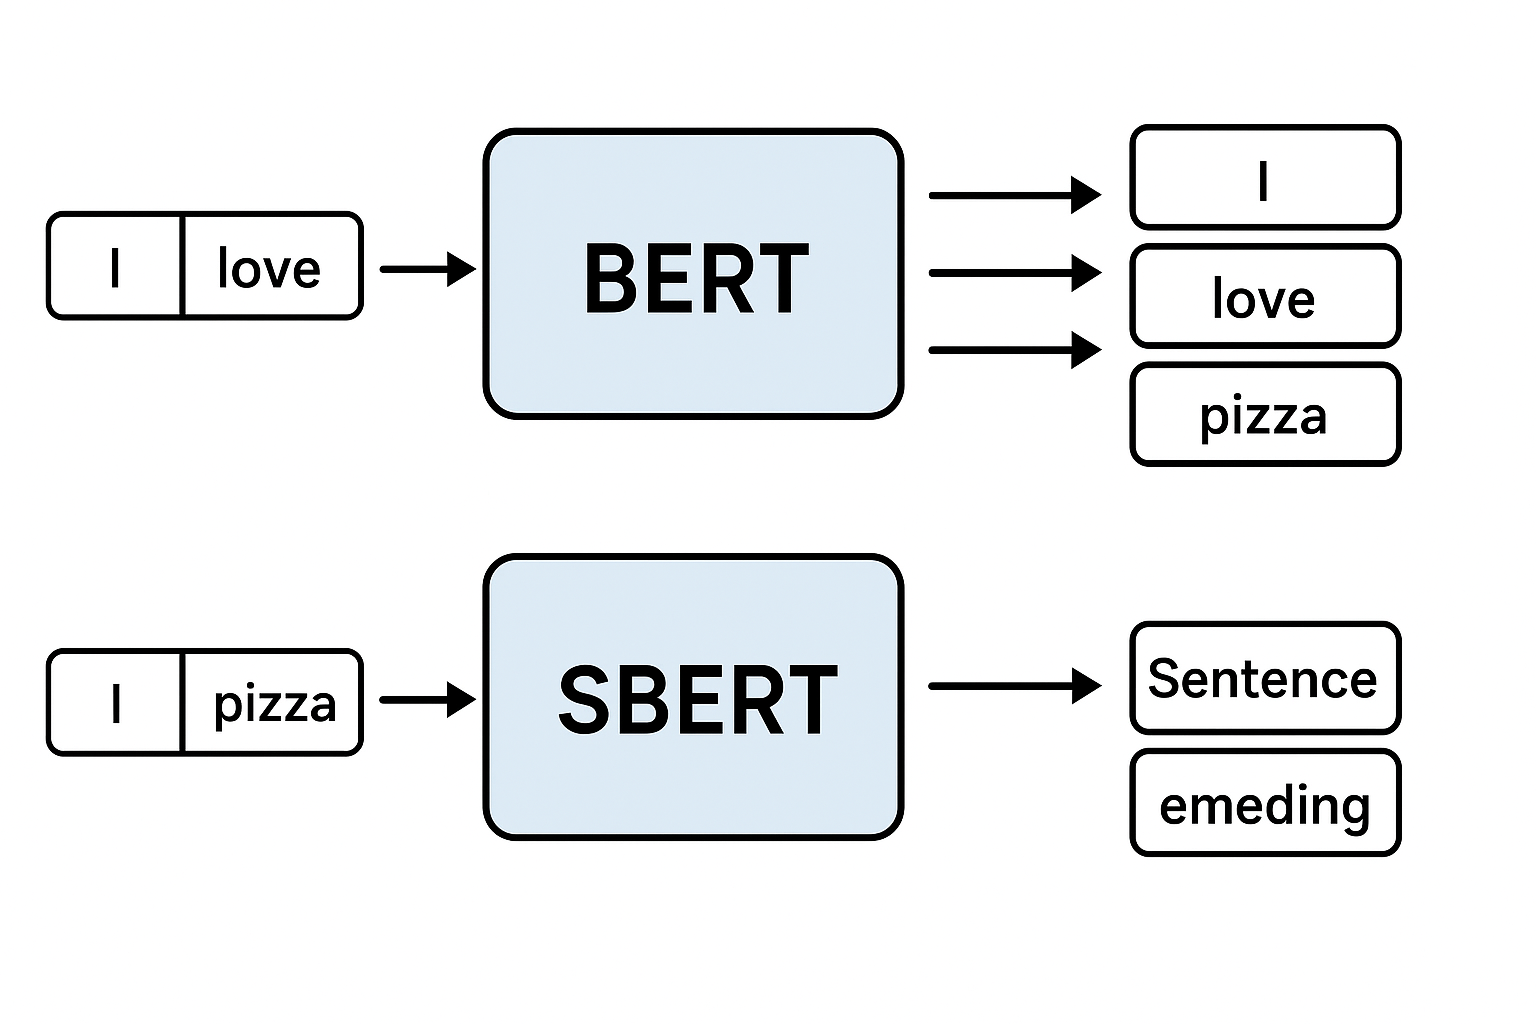

BERT → Good if you want to understand or classify sentences, e.g., sentiment, QA.

SBERT → Good if you want to measure similarity between sentences or search for similar sentences

# **SBERT + LOGISTIC REGRESSION**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=16,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)
X = embeddings  # no need to reshape for Logistic Regression
y = np.array(y_cleaned)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("[INFO] Training Logistic Regression...")
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = clf.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + Logistic Regression Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + XGBOOST**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=16,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)
X = embeddings  # shape: (num_samples, 384)
y = np.array(y_cleaned)

# ------------------------- 2. Split dataset -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# ------------------------- 5. Bar plot visualization -------------------------
scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + XGBoost Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + RANDOMFOREST**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=16,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)
X = embeddings
y = np.array(y_cleaned)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=20,           # limit depth to avoid overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['steelblue','lightgreen','salmon','gold'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + LightGBM**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import lightgbm as lgb


print("[INFO] Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("[INFO] Encoding sentences...")
embeddings = sbert_model.encode(
    list(X_cleaned),
    batch_size=16,
    show_progress_bar=True
)

print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 384)
X = embeddings
y = np.array(y_cleaned)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training LightGBM classifier...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,        # number of boosting rounds
    learning_rate=0.05,      # shrinkage rate
    max_depth=-1,            # unlimited depth
    num_leaves=64,           # controls complexity
    min_child_samples=30,
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)




In [ ]:
y_pred = lgb_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['dodgerblue','limegreen','tomato','gold'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("SBERT + LightGBM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


**DISTILBERT**

**1.Distilled Model 🔥**

DistilBERT is a compressed version of BERT, created using knowledge distillation.

It keeps ~97% of BERT’s performance while being much smaller and faster.

**2.Size Reduction 📉**

DistilBERT has 66 million parameters, about 40% fewer than BERT-base (110M).

**3.Speed & Memory ⚡**

Runs about 60% faster than BERT-base.

Requires less GPU/CPU memory, making it suitable for real-time or resource-constrained environments.

**4.Architecture 🏗️**

DistilBERT has 6 Transformer layers (BERT-base has 12).

Hidden size = 768, attention heads = 12.

**5.Outputs 🔄**

Like BERT, it produces token embeddings and a [CLS] embedding for sentence-level tasks.

**6.Pre-training 📚**

Trained on the same corpus as BERT (BooksCorpus + English Wikipedia).

Objective: Masked Language Modeling (MLM) + Distillation loss from BERT.

**7.No Next Sentence Prediction (NSP) 🚫**

DistilBERT skips the NSP task used in BERT pretraining, but still performs well on downstream tasks.

**8.General Purpose 🛠️**

Can be fine-tuned for text classification, sentiment analysis, NER, question answering, sarcasm detection, etc.

**9.Embeddings Dimension 📏**

CLS embeddings = 768-dimensional (same as BERT-base).

SBERT, by contrast, often reduces embeddings (e.g., 384-dim in all-MiniLM-L6-v2).

**10.Trade-off ⚖️**

Pros: Faster, lighter, still powerful.

Cons: Slightly less accurate than BERT/SBERT for some semantic tasks unless fine-tuned.

## **performance is weaker than SBERT**

| Feature                     | **DistilBERT**                                                                | **SBERT (Sentence-BERT)**                                                                  |
| --------------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ |
| **Origin**                  | Distilled version of **BERT-base**                                            | Based on **BERT/DistilBERT/MiniLM**, fine-tuned for sentence embeddings                    |
| **Architecture**            | 6 transformer layers (half of BERT-base)                                      | Same as underlying BERT/DistilBERT but modified pooling                                    |
| **Embedding Dimension**     | 768 (CLS token)                                                               | Usually 384 (MiniLM) or 768 (BERT-based models)                                            |
| **Training Objective**      | Masked Language Modeling (MLM) + Distillation loss                            | Sentence similarity (Natural Language Inference, Semantic Textual Similarity)              |
| **Sentence Representation** | Uses **[CLS] token embedding**                                                | Uses **mean pooling / CLS pooling** optimized for semantic similarity                      |
| **Best Use Case**           | Token-level tasks, fine-tuning for classification, NER, QA                    | Sentence-level tasks: semantic similarity, clustering, classification                      |
| **Performance**             | Fast, lighter, but raw embeddings are not optimized for sentence meaning      | Out-of-the-box embeddings capture sentence semantics much better                           |
| **Fine-tuning**             | Needs fine-tuning for sentence-level classification (e.g., sarcasm detection) | Works well even without fine-tuning, but can be fine-tuned further                         |
| **Speed**                   | ~60% faster than BERT                                                         | Slightly slower than DistilBERT (depending on variant), but embeddings are more meaningful |
| **Use in ML Pipelines**     | Extract CLS → use with ML model (needs tuning)                                | Direct embeddings → plug into ML models (works great)                                      |


DistilBERT:
Sentence = “I failed my exam, amazing!”
→ CLS vector = general-purpose representation (not guaranteed to capture sarcasm).

SBERT:
Same sentence → embedding is optimized to capture meaning and tone relative to other sentences → better for classification like “self-sarcasm vs not”.

# **DISTILBERT + LSTM**

DistilBERT just as an embedding extractor (frozen) and then train a separate LSTM model on those embeddings.


| Aspect           | Frozen             | Fine-tuned                      |
| ---------------- | ------------------ | ------------------------------- |
| Model weights    | Fixed, not updated | Updated during training         |
| Training speed   | Faster             | Slower                          |
| GPU/memory usage | Lower              | Higher                          |
| Overfitting risk | Lower              | Higher (if small dataset)       |
| Accuracy         | Good baseline      | Can be better if data is enough |


**Small dataset** → use frozen embeddings + LSTM

**Large dataset** → fine-tune DistilBERT + LSTM for best performance

“Hey, don’t just use BERT’s embeddings — also update all of its 66+ million parameters during training!”

**⚙️ What actually happens:**
**✅ Pros (Advantages):**

Learns task-specific meaning
→ The model adapts the embeddings to your dataset (great if you have a large, high-quality dataset).

**Can achieve higher accuracy**
→ Especially on text tasks where domain language is unique (e.g., sarcasm, resumes, tweets).

❌ Cons (Risks): **bold text**

Very heavy computation
→ Training becomes 10× slower (BERT layers are huge).

**Needs a lot of memory (GPU/TPU)**
→ If running on Colab CPU or single GPU, it may crash or run extremely slow.

**Overfitting**
→ If you have limited data (say <20k samples), the model will memorize your data rather than generalize.

**Unstable training**
→ Fine-tuning all transformer layers often needs a very low learning rate (1e-5 or 2e-5). Otherwise, gradients explode.



distilbert.trainable = True


| Setting                              | Description                | Suitable When         | Speed       | Overfitting Risk |
| ------------------------------------ | -------------------------- | --------------------- | ----------- | ---------------- |
| `trainable = False`                  | Use frozen BERT embeddings | Small dataset (<5k)   | ⚡ Fast      | 🔹 Low           |
| `trainable = True`                   | Train all BERT layers      | Large dataset (>50k)  | 🐢 Slow     | 🔴 High          |
| ✅ Partial unfreeze (last 1–2 layers) | Fine-tune top layers only  | Medium dataset (~10k) | ⚖️ Balanced | 🟡 Moderate      |


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)

# Freeze BERT layers
distilbert.trainable = False


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])

x = LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")
model.summary()

In [ ]:
y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + LSTM Fine-Tuned Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT * + BILSTM**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4


print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)

# Freeze BERT for faster training
distilbert.trainable = False

# ---------------- TOKENIZE ----------------
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)

input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = DistilBertEmbeddingLayer(distilbert)(
    [input_ids_layer, attention_mask_layer]
)

x = Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(3e-5))
)(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(3e-5))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + BiLSTM Fine-Tuned Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + GRU**

| Feature              | LSTM                                | GRU                                 |
| -------------------- | ----------------------------------- | ----------------------------------- |
| **Architecture**     | Has 3 gates (input, forget, output) | Has 2 gates (reset, update)         |
| **Complexity**       | More parameters → slower            | Fewer parameters → faster           |
| **Memory handling**  | Good at long-term dependencies      | Efficient for short & medium text   |
| **Training speed**   | Slow                                | Faster convergence                  |
| **Overfitting risk** | Higher (more params)                | Lower (simpler structure)           |
| **Recommended for**  | Long sequences (paragraphs)         | Tweets, comments, sarcasm detection |


| Property             | GRU                      | LSTM                      |
| -------------------- | ------------------------ | ------------------------- |
| Works for prediction | ✅ Yes                    | ✅ Yes                     |
| Compatible with BERT | ✅ Yes                    | ✅ Yes                     |
| Speed                | ⚡ Faster                 | 🐢 Slower                 |
| Generalization       | 👍 Better for small data | ⚖️ Depends on data length |


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)

# Freeze BERT layers for feature extraction
distilbert.trainable = False


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])


x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")




In [ ]:
y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + Gru Fine-Tuned Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **DISTILBERT + BIGRU**

| Model     | Reads Text         | Captures Context | Speed              | Works Well for                                    |
| --------- | ------------------ | ---------------- | ------------------ | ------------------------------------------------- |
| GRU       | Forward only       | Limited          | ⚡ Fast             | Short, directional text                           |
| **BiGRU** | Forward + Backward | Richer context   | ⚙️ Slightly slower | Text classification, sentiment, sarcasm detection |


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)

# Freeze BERT layers for feature extraction
distilbert.trainable = False


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])


from tensorflow.keras.layers import Bidirectional


x = Bidirectional(
        GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))
    )(bert_embeddings)

x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")




In [ ]:
y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + BIGRU Fine-Tuned Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **DISTILBERT + Logistic Regression**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


MAX_LEN = 256
BATCH_SIZE = 16
print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False

encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Extracting DistilBERT embeddings in batches...")

embeddings_list = []
for i in range(0, len(input_ids), BATCH_SIZE):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    embeddings_list.append(batch_embeddings)

embeddings = np.concatenate(embeddings_list, axis=0)
print(f"[INFO] Finished embedding extraction. Shape: {embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42
)


print("[INFO] Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + Logistic Regression Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


# **DISTILBERT + RandomForestclassifier**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


MAX_LEN = 256
BATCH_SIZE = 16
print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False  # Freeze DistilBERT for feature extraction


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Extracting DistilBERT embeddings in batches...")

embeddings_list = []
for i in range(0, len(input_ids), BATCH_SIZE):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token
    embeddings_list.append(batch_embeddings)

embeddings = np.concatenate(embeddings_list, axis=0)
print(f"[INFO] Finished embedding extraction. Shape: {embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42
)


print("[INFO] Training Random Forest model...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)


y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + XGBoost**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


MAX_LEN = 256
BATCH_SIZE = 16
print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False  # Freeze DistilBERT for feature extraction


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Extracting DistilBERT embeddings in batches...")

embeddings_list = []
for i in range(0, len(input_ids), BATCH_SIZE):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token
    embeddings_list.append(batch_embeddings)

embeddings = np.concatenate(embeddings_list, axis=0)
print(f"[INFO] Finished embedding extraction. Shape: {embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42
)

print("[INFO] Training XGBoost model...")
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_clf.fit(X_train, y_train)



In [ ]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + LIGHTgbm**

Absolutely 👍 — let’s break down all the **important LightGBM parameters** used in your model:

---

### 🌟 **LightGBM Overview**

LightGBM (**Light Gradient Boosting Machine**) is a powerful, fast, and efficient gradient boosting framework developed by Microsoft.
It’s especially good for:

* Large datasets
* Handling categorical and numerical features efficiently
* Faster training than XGBoost with similar or better accuracy

---

### ⚙️ **Parameters Used in Your Code**

#### 🧩 1. `n_estimators=300`

* This means **300 decision trees** will be built sequentially.
* More trees → higher accuracy (but may increase overfitting).
* You can tune it (e.g. try 100, 300, 500).

💡 *Think of it as the number of boosting rounds.*

---

#### 🧩 2. `learning_rate=0.05`

* Controls **how much each new tree** contributes to the overall model.
* Smaller value → slower learning → needs more trees.
* Larger value → faster learning but risk of overfitting.

💡 *Common range: 0.01 – 0.1.*

---

#### 🧩 3. `max_depth=-1`

* Defines how deep each tree can go.
* `-1` means **no limit**, allowing the model to find complex patterns.
* But deeper trees can overfit small datasets.

💡 *For smaller datasets, try limiting to 6–12.*

---

#### 🧩 4. `num_leaves=31`

* Controls the **complexity of each tree**.
* The higher the number of leaves, the more complex the model.
* Rough guideline:

  ```
  num_leaves ≈ 2^(max_depth)
  ```

💡 *For example, max_depth=6 → num_leaves around 64.*

---

#### 🧩 5. `subsample=0.8`

* Uses **80% of data randomly** for each tree.
* Helps prevent overfitting by introducing randomness.

💡 *Think of it as “row sampling.”*

---

#### 🧩 6. `colsample_bytree=0.8`

* Uses **80% of features** for each tree.
* Also helps prevent overfitting by introducing feature randomness.

💡 *Think of it as “column sampling.”*

---

#### 🧩 7. `random_state=42`

* Sets the random seed for reproducibility.
* Ensures you get the same results each time you run the code.

---

### 🧠 **Additional Useful Parameters (Optional)**

| Parameter           | Meaning                        | Typical Value                                          |
| ------------------- | ------------------------------ | ------------------------------------------------------ |
| `min_child_samples` | Minimum data points in a leaf  | 20–50                                                  |
| `reg_alpha`         | L1 regularization (sparsity)   | 0–1                                                    |
| `reg_lambda`        | L2 regularization (smoothness) | 0–1                                                    |
| `objective`         | Type of task                   | `"binary"` for 2-class, `"multiclass"` for multi-class |
| `boosting_type`     | Type of boosting               | `"gbdt"` (default), `"dart"`, `"goss"`                 |

---

### 📊 **How It Works (Simplified)**

1. LightGBM builds the **first tree** to make an initial prediction.
2. It checks the **error** and builds the **next tree** to fix that error.
3. Each new tree tries to correct previous mistakes (gradient boosting).
4. Final prediction = sum of all tree outputs (weighted by learning_rate).

---

Would you like me to show you a **parameter tuning guide** (how to adjust `num_leaves`, `max_depth`, and `learning_rate` for best accuracy and less overfitting)?


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


MAX_LEN = 256
BATCH_SIZE = 16
print("[INFO] Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False  # Freeze DistilBERT for feature extraction


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Extracting DistilBERT embeddings in batches...")

embeddings_list = []
for i in range(0, len(input_ids), BATCH_SIZE):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token
    embeddings_list.append(batch_embeddings)

embeddings = np.concatenate(embeddings_list, axis=0)
print(f"[INFO] Finished embedding extraction. Shape: {embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42
)

print("[INFO] Training LightGBM model...")
lgbm_clf = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,          # -1 means no limit
    num_leaves=31,         # controls model complexity
    subsample=0.8,         # randomly sample 80% of data per tree
    colsample_bytree=0.8,  # randomly sample 80% of features per tree
    random_state=42
)

lgbm_clf.fit(X_train, y_train)


In [ ]:
y_pred = lgbm_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("DistilBERT + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **ROBERTA + LSTM**

| Feature                 | DistilBERT                  | RoBERTa                                                |
| ----------------------- | --------------------------- | ------------------------------------------------------ |
| Size                    | Smaller (66M params)        | Larger (125M params for base)                          |
| Training Data           | Wikipedia + BookCorpus      | More robust: BookCorpus, CC-News, OpenWebText, Stories |
| Fine-tuning Performance | Good, fast                  | Usually better accuracy on nuanced tasks               |
| Speed                   | Faster, lighter             | Slower, heavier                                        |
| Use Case                | Lightweight, fast inference | High accuracy for semantic understanding               |


| Model                        | Key Features                                           | Pros                                                                     | Cons                                                    | Likely Performance for “self-comment detection”                       |
| ---------------------------- | ------------------------------------------------------ | ------------------------------------------------------------------------ | ------------------------------------------------------- | --------------------------------------------------------------------- |
| **BERT (bert-base-uncased)** | 12-layer Transformer, 110M params                      | Good general understanding, widely used, strong semantic capture         | Slow to train, heavy                                    | Strong baseline, usually accurate                                     |
| **DistilBERT**               | Smaller, distilled version of BERT, 66M params         | Faster, lighter, less memory                                             | Slightly lower accuracy than BERT                       | Good if speed is important, may miss subtle semantics                 |
| **RoBERTa (roberta-base)**   | BERT variant trained on more data, robust, 125M params | Usually outperforms BERT on text classification, captures nuances better | Heavier, slower                                         | Best for subtle semantic detection like self-comment vs other-comment |
| **SBERT / Sentence-BERT**    | Optimized for sentence embeddings & similarity         | Excellent for semantic similarity, clustering, or retrieval              | Not a classifier out-of-the-box; needs extra classifier | Works best if you convert task to embedding + classifier approach     |


| Priority                                      | Recommended Model    |
| --------------------------------------------- | -------------------- |
| Maximum Accuracy                              | RoBERTa (fine-tuned) |
| Faster Training / Smaller Dataset             | DistilBERT           |
| Semantic Embeddings / Future Similarity Tasks | SBERT                |



| Model                             | Size / Params                | Pros                                                         | Cons                                       | Fit for Self-Comment Detection                                                |
| --------------------------------- | ---------------------------- | ------------------------------------------------------------ | ------------------------------------------ | ----------------------------------------------------------------------------- |
| **BERT-base (bert-base-uncased)** | 12 layers, 110M              | Strong semantic understanding, widely tested                 | Slower, heavy                              | Good baseline; can work well if fine-tuned                                    |
| **RoBERTa-base**                  | 12 layers, 125M              | BERT variant trained on more data, better at nuances         | Slower, heavier                            | **Best choice** for subtle semantic differences (like self-comment detection) |
| **DistilBERT**                    | 6 layers, 66M                | Lightweight, faster training and inference                   | Slightly less accurate                     | Works if speed is important or dataset is small                               |
| **ALBERT**                        | 12–24M (parameter-efficient) | Smaller, faster, less memory                                 | May underperform on nuanced classification | Could work, but not optimal for subtle semantic tasks                         |
| **SBERT**                         | Embedding-focused            | Excellent for semantic similarity and sentence-level meaning | Not a classifier by itself                 | Can be combined with a classifier; good for semantic-heavy tasks              |


In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze RoBERTa layers for feature extraction
roberta_model.trainable = False
roberta_model.trainable = False
for layer in roberta_model.layers[-2:]:  # last 2 layers
    layer.trainable = True



encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # shape: (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)


print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_pred_probs = model.predict([X_test_ids, X_test_mask])
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(ROBERTA + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **ROBERTA + BILSTM**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4


print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


# Freeze all layers first
for layer in roberta_model.layers:
    layer.trainable = False

# Unfreeze last 2 layers for task-specific tuning
for layer in roberta_model.layers[-2:]:
    layer.trainable = True


encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])

x = Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(3e-5))
)(bert_embeddings)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_pred_probs = model.predict([X_test_ids, X_test_mask])
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(ROBERTA + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **ROBERTa + GRU**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers first
for layer in roberta_model.layers:
    layer.trainable = False

# Unfreeze last 2 layers for task-specific tuning
for layer in roberta_model.layers[-2:]:
    layer.trainable = True

# ---------------- TOKENIZATION ----------------
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



y_pred_probs = model.predict([X_test_ids, X_test_mask])
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(ROBERTA + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()



In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **ROBERTa + BIGRU**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers first
for layer in roberta_model.layers:
    layer.trainable = False

# Unfreeze last 2 layers for task-specific tuning
for layer in roberta_model.layers[-2:]:
    layer.trainable = True

encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids_np, attention_mask_np, y, test_size=0.2, random_state=42
)

class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, 768)

input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = Bidirectional(
    GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))
)(bert_embeddings)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

print("[INFO] Training started...")
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"[INFO] Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



y_pred_probs = model.predict([X_test_ids, X_test_mask])
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



y_pred_prob = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_mask})
y_pred = (y_pred_prob > 0.5).astype(int)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(ROBERTA + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()



In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **ROBERTa + RandomforestClassifier**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf


MAX_LEN = 256
BATCH_SIZE = 16


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers to save memory
for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing sentences...")
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Computing RoBERTa embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)

for batch in dataset:
    batch_input_ids, batch_attention_mask = batch
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)
    # Use mean pooling over sequence length
    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 768)

X = embeddings


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred = rf_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()





scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['steelblue','lightgreen','salmon','gold'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("RoBERTa + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **ROBERTa + Logistic Regression**

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm  # ✅ for progress bar

# Configuration
MAX_LEN = 256
BATCH_SIZE = 32

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base").to(device)
model.eval()

# Tokenize
print("[INFO] Tokenizing sentences...")
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)

# Compute embeddings
print("[INFO] Computing RoBERTa embeddings...")

embeddings_list = []
num_batches = len(input_ids) // BATCH_SIZE + int(len(input_ids) % BATCH_SIZE != 0)

# ✅ Show progress bar
with torch.no_grad():
    for i in tqdm(range(0, len(input_ids), BATCH_SIZE), total=num_batches, desc="Embedding Batches"):
        batch_input = input_ids[i:i+BATCH_SIZE].to(device)
        batch_mask = attention_mask[i:i+BATCH_SIZE].to(device)
        outputs = model(batch_input, attention_mask=batch_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings_list.append(batch_embeddings.cpu())

embeddings = torch.cat(embeddings_list).numpy()
print(f"[INFO] Embeddings shape: {embeddings.shape}")

# Scale and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Train classifier
print("[INFO] Training Logistic Regression classifier...")
logreg_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
logreg_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred = logreg_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['steelblue','lightgreen','salmon','gold'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("RoBERTa + Logistic Regression Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **ROBERTa + XGBOOST**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from xgboost import XGBClassifier


MAX_LEN = 256
BATCH_SIZE = 16


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers to save memory
for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing sentences...")
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Computing RoBERTa embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)


for batch_input_ids, batch_attention_mask in tqdm(dataset, desc="Embedding Batches"):
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)

    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {embeddings.shape}")

X = embeddings


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training XGBoost classifier...")
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="gpu_hist" if tf.config.list_physical_devices('GPU') else "hist",
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)



y_pred = xgb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


metrics = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['steelblue', 'lightgreen', 'salmon', 'gold'])
for bar, score in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0, 1.1)
plt.title("RoBERTa + XGBoost Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred = logreg_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# **ROBERTA + LIGHTgbm**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from lightgbm import LGBMClassifier


MAX_LEN = 256
BATCH_SIZE = 16


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers to save memory
for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing sentences...")
encodings = tokenizer(
    list(X_cleaned),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
y = np.array(y_cleaned)


print("[INFO] Computing RoBERTa embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)


for batch_input_ids, batch_attention_mask in tqdm(dataset, desc="Embedding Batches"):
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)
    # Mean pooling over sequence length
    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {embeddings.shape}")  # (num_samples, 768)

X = embeddings

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("[INFO] Training LightGBM classifier...")
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    boosting_type='gbdt',
    device='gpu' if tf.config.list_physical_devices('GPU') else 'cpu'
)

lgbm_model.fit(X_train, y_train)


y_pred = lgbm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


metrics = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['steelblue', 'lightgreen', 'salmon', 'gold'])
for bar, score in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0, 1.1)
plt.title("RoBERTa + LightGBM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred = lgbm_model.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_score:.4f}")
print(f"Precision: {prec_score:.4f}")
print(f"Recall: {rec_score:.4f}")
print(f"F1-score: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


metrics = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['steelblue', 'lightgreen', 'salmon', 'gold'])
for bar, score in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0, 1.1)
plt.title("RoBERTa + LightGBM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()



# **GLOVE EMBEDDING SYSTEM**

| Model                       | Dim     | Memory       | Speed        | Best for                                |
| --------------------------- | ------- | ------------ | ------------ | --------------------------------------- |
| glove-wiki-gigaword-50      | 50      | Fastest      | Fast         | Simple short-text tasks                 |
| **glove-wiki-gigaword-100** | **100** | **Moderate** | **Balanced** | **Tweets, comments, social media text** |
| glove-wiki-gigaword-200     | 200     | Slower       | Medium       | Sentiment or topic tasks                |
| glove-wiki-gigaword-300     | 300     | Heaviest     | Slow         | Large corpus + deep semantic tasks      |


**GloVe** (Global Vectors for Word Representation) is a static word embedding method created by Stanford.

**Key points:**

Each word is represented by a fixed vector (e.g., 50, 100, 200, 300 dimensions).

Trained on word co-occurrence statistics in a large corpus (e.g., Wikipedia + Gigaword).

**Captures general semantic meaning, e.g.:**
vec("king") - vec("man") + vec("woman") ≈ vec("queen")
Fast and lightweight.

**Static**: Same vector for a word in any context.

**Pros:**

Simple to use.

Works well for small datasets.

Low memory usage compared to transformers.

**Cons:**

Cannot handle contextual meaning (e.g., “bank” as river vs. money).

Cannot understand polysemy or sarcasm easily.

| Feature                   | GloVe                        | BERT                             |
| ------------------------- | ---------------------------- | -------------------------------- |
| Type                      | Static embeddings            | Contextual embeddings            |
| Word vector dimension     | 50, 100, 200, 300            | 768 (base) / 1024 (large)        |
| Context awareness         | No                           | Yes                              |
| Training data             | Wikipedia + Gigaword         | Wikipedia + BookCorpus           |
| Computational cost        | Low                          | High                             |
| Memory usage              | Low                          | High                             |
| Best for                  | Small datasets, simple tasks | Large datasets, contextual tasks |
| Handling polysemy/sarcasm | Poor                         | Excellent                        |


We use **Gensim** because it’s a powerful Python library for **natural language processing (NLP)**, especially for handling **word embeddings and topic modeling** efficiently. Let me break it down clearly:

---

## **1️⃣ Main Reasons to Use Gensim**

### **a) Pretrained Word Embeddings**

* Gensim provides easy access to pretrained embeddings like **GloVe, Word2Vec, FastText**.
* You can **load embeddings** quickly and convert words to vectors.

```python
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-100")
vector = glove['king']  # get 100-dim vector for 'king'
```

---

### **b) Efficient Memory Usage**

* Handles **large text corpora** without loading everything into memory.
* Streams data and builds models incrementally, which is **faster and memory-friendly** than vanilla Python methods.

---

### **c) Unsupervised NLP Models**

* Supports training your own **Word2Vec**, **FastText**, **Doc2Vec** models on custom text.
* Good for **semantic similarity, clustering, topic modeling**.

```python
from gensim.models import Word2Vec
sentences = [["i", "love", "nlp"], ["nlp", "is", "fun"]]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)
```

---

### **d) Semantic Similarity**

* Find **similar words** or **word relationships** easily.

```python
glove.most_similar('king')
# Returns words like 'queen', 'prince', etc.
```

---

### **e) Easy Integration with ML Pipelines**

* Gensim vectors can be used as input to **scikit-learn, XGBoost, LightGBM**, etc.
* Works well when you want **classic ML algorithms instead of deep learning**.

---

## **2️⃣ Why Gensim for GloVe?**

* GloVe embeddings come as **pretrained vector files**.
* Gensim makes it **easy to load, query, and manipulate these vectors** without manually parsing the files.
* Efficient for datasets like **tweets or comments**, where you might average word vectors to get sentence embeddings.

---

💡 **Summary:**

* Use **Gensim** to **load embeddings**, **train Word2Vec/Doc2Vec**, **compute similarity**, and integrate into ML pipelines efficiently.
* It’s lightweight, memory-efficient, and great for **classic ML approaches** with embeddings.

---




**Gensim**

In [ ]:
!pip install --upgrade gensim==4.3.3


In [ ]:
import numpy as np
import gensim

print("NumPy version:", np.__version__)
print("Gensim version:", gensim.__version__)


In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


print("[INFO] Loading GloVe embeddings (may take a minute)...")
glove = api.load("glove-wiki-gigaword-200")  # 100D GloVe vectors

# ---------------- TEXT TO VECTOR FUNCTION ----------------
def sentence_to_glove_vector(sentence):
    words = sentence.split()
    word_vecs = [glove[word] for word in words if word in glove]
    if len(word_vecs) == 0:
        return np.zeros(100)  # empty sentence fallback
    return np.mean(word_vecs, axis=0)


print("[INFO] Generating GloVe embeddings for all texts...")
X_vectors = np.array([sentence_to_glove_vector(text) for text in tqdm(X_cleaned)])
y = np.array(y_cleaned)

print(f"[INFO] Embedding shape: {X_vectors.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42
)


print("[INFO] Training LightGBM model...")
lgbm_clf = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LightGBM)')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LightGBM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **GLOVE + XGBOOST**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("[INFO] Loading GloVe embeddings (may take a minute)...")
glove = api.load("glove-wiki-gigaword-200")  # 200D GloVe vectors

def sentence_to_glove_vector(sentence):
    words = sentence.split()
    word_vecs = [glove[word] for word in words if word in glove]
    if len(word_vecs) == 0:
        return np.zeros(200)  # empty sentence fallback
    return np.mean(word_vecs, axis=0)


print("[INFO] Generating GloVe embeddings for all texts...")
X_vectors = np.array([sentence_to_glove_vector(text) for text in tqdm(X_cleaned)])
y = np.array(y_cleaned)

print(f"[INFO] Embedding shape: {X_vectors.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42
)


print("[INFO] Training XGBoost model...")
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)


In [ ]:
y_pred = xgb_clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + XGBoost)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + XGBoost Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **GLOVE + Logistic regression**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("[INFO] Loading GloVe embeddings (may take a minute)...")
glove = api.load("glove-wiki-gigaword-200")  # 200D GloVe vectors

def sentence_to_glove_vector(sentence):
    words = sentence.split()
    word_vecs = [glove[word] for word in words if word in glove]
    if len(word_vecs) == 0:
        return np.zeros(200)  # empty sentence fallback
    return np.mean(word_vecs, axis=0)


print("[INFO] Generating GloVe embeddings for all texts...")
X_vectors = np.array([sentence_to_glove_vector(text) for text in tqdm(X_cleaned)])
y = np.array(y_cleaned)

print(f"[INFO] Embedding shape: {X_vectors.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42
)


print("[INFO] Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)


In [ ]:
y_pred = clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + Logistic Regression)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + Logistic Regression Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **GLOVE + Randomforest**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("[INFO] Loading GloVe embeddings (may take a minute)...")
glove = api.load("glove-wiki-gigaword-200")  # 200D GloVe vectors


def sentence_to_glove_vector(sentence):
    words = sentence.split()
    word_vecs = [glove[word] for word in words if word in glove]
    if len(word_vecs) == 0:
        return np.zeros(200)  # empty sentence fallback
    return np.mean(word_vecs, axis=0)


print("[INFO] Generating GloVe embeddings for all texts...")
X_vectors = np.array([sentence_to_glove_vector(text) for text in tqdm(X_cleaned)])
y = np.array(y_cleaned)

print(f"[INFO] Embedding shape: {X_vectors.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42
)


print("[INFO] Training Random Forest model...")
rf_clf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # no depth limit
    random_state=42,
    n_jobs=-1              # use all CPU cores
)
rf_clf.fit(X_train, y_train)


In [ ]:
y_pred = rf_clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **GLOVE + LSTM**

In [ ]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

MAX_LEN = 256
EMBEDDING_DIM = 200
BATCH_SIZE = 32
EPOCHS = 15
DROPOUT_RATE = 0.5
L2_REG = 1e-4
VALIDATION_SPLIT = 0.2

print("[INFO] Loading GloVe embeddings (may take a while)...")
glove = api.load("glove-wiki-gigaword-200")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
word_index = tokenizer.word_index
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in glove:
        embedding_matrix[i] = glove[word]

y = np.array(y_cleaned)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=VALIDATION_SPLIT, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
print("[INFO] Training started...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


In [ ]:

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **GLOVE + BILSTM**

In [ ]:

import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers


MAX_LEN = 256
EMBEDDING_DIM = 200
BATCH_SIZE = 32
EPOCHS = 10


print("[INFO] Loading GloVe embeddings (may take a while)...")
glove = api.load("glove-wiki-gigaword-200")


def sentence_to_glove_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating GloVe sequences for all texts...")
X_seq = [sentence_to_glove_sequence(text) for text in X_cleaned]


X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)


model = Sequential()
model.add(Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(3e-5)),
    input_shape=(MAX_LEN, EMBEDDING_DIM)
))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


In [ ]:

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **GLOVE + GRU**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras import regularizers

MAX_LEN = 256
EMBEDDING_DIM = 200
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading GloVe embeddings (may take a while)...")
glove = api.load("glove-wiki-gigaword-200")

def sentence_to_glove_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove]
    if len(vecs) == 0:
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs

print("[INFO] Generating GloVe sequences for all texts...")
X_seq = [sentence_to_glove_sequence(text) for text in X_cleaned]

X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(GRU(
    64,
    return_sequences=False,
    kernel_regularizer=regularizers.l2(1e-4),
    input_shape=(MAX_LEN, EMBEDDING_DIM)
))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **GLOVE + BIGRU**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers


MAX_LEN = 256
EMBEDDING_DIM = 200
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading GloVe embeddings (may take a while)...")
glove = api.load("glove-wiki-gigaword-200")


def sentence_to_glove_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove]
    if len(vecs) == 0:
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating GloVe sequences for all texts...")
X_seq = [sentence_to_glove_sequence(text) for text in X_cleaned]

X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(Bidirectional(
    GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)),
    input_shape=(MAX_LEN, EMBEDDING_DIM)
))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **word2vec + LSTM**

In [ ]:
!pip install --upgrade gensim==4.3.3



In [ ]:
import numpy as np
import gensim

print("NumPy version:", np.__version__)
print("Gensim version:", gensim.__version__)

In [ ]:

import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10


print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")


def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]


X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)


model = Sequential()
model.add(LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4),
               input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
     callbacks=[early_stopping],
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **word2vec + BILSTM**

In [ ]:

import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10


print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")


def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]


X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)),
                        input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
     callbacks=[early_stopping],
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **WORD2VEC + GRU**

In [ ]:

import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10


print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")


def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]


X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(GRU(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4),
              input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
     callbacks=[early_stopping],
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **GLOVE + BIGRU**

In [ ]:

import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10


print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")


def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs


print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]


X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)),
                           input_shape=(MAX_LEN, EMBEDDING_DIM)))

model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("[INFO] Training started...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
     callbacks=[early_stopping],
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (GloVe + LSTM)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + LSTM Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **GLOVE + Logistic regression**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")

def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs

print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]

# PAD THE SEQUENCES FIRST
X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

# Split the ALREADY PADDED sequences
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

print("\n[INFO] Training Logistic Regression model...")

# Now we can safely use np.mean on the padded arrays
X_train_avg = np.mean(X_train, axis=1)
X_test_avg = np.mean(X_test, axis=1)

print(f"[INFO] Shape of features for Logistic Regression: {X_train_avg.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_avg)
X_test_scaled = scaler.transform(X_test_avg)

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)

lr_model.fit(X_train_scaled, y_train)



In [ ]:
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


acc_score = accuracy_score(y_test, y_pred_lr)
prec_score = precision_score(y_test, y_pred_lr)
rec_score = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("GloVe + Logistic regression Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **word2vec + Randomforest classifier**

In [ ]:
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")

def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs

print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]

X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

print("[INFO] Training Random Forest model...")

# OPTION 1: Average Pooling (Recommended - reduces dimensionality)
X_avg = np.mean(X_padded, axis=1)  # Shape: (n_samples, 300)
print(f"[INFO] Shape after average pooling: {X_avg.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_avg, y, test_size=0.2, random_state=42
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Word2Vec + Random Forest Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **word2vec + Xgboost**

In [ ]:
import numpy as np
import gensim.downloader as api
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")

def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs

print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]

X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

print("[INFO] Training Random Forest model...")

# OPTION 1: Average Pooling (Recommended - reduces dimensionality)
X_avg = np.mean(X_padded, axis=1)  # Shape: (n_samples, 300)
print(f"[INFO] Shape after average pooling: {X_avg.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_avg, y, test_size=0.2, random_state=42
)
print("[INFO] Training XGBoost model...")
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)



In [ ]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Word2Vec + Xgboost Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **word2vec + Lightgbm**

In [ ]:
import numpy as np
import gensim.downloader as api
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

MAX_LEN = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10

print("[INFO] Loading word2vec embeddings (may take a while)...")
w2v = api.load("word2vec-google-news-300")

def sentence_to_w2v_sequence(sentence, max_len=MAX_LEN):
    words = sentence.split()
    vecs = [w2v[word] for word in words if word in w2v]
    if len(vecs) == 0:  # fallback for empty sentence
        vecs = [np.zeros(EMBEDDING_DIM)]
    return vecs

print("[INFO] Generating word2vec sequences for all texts...")
X_seq = [sentence_to_w2v_sequence(text) for text in X_cleaned]

X_padded = pad_sequences(
    X_seq,
    maxlen=MAX_LEN,
    dtype='float32',
    padding='post',
    truncating='post',
    value=0.0
)

y = np.array(y_cleaned)
print(f"[INFO] Shape of padded sequences: {X_padded.shape}")

print("[INFO] Training Random Forest model...")

# OPTION 1: Average Pooling (Recommended - reduces dimensionality)
X_avg = np.mean(X_padded, axis=1)  # Shape: (n_samples, 300)
print(f"[INFO] Shape after average pooling: {X_avg.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_avg, y, test_size=0.2, random_state=42
)
print("[INFO] Training Lightgbm model...")
clf_lgb = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)


clf_lgb.fit(X_train, y_train)






In [ ]:
y_pred = clf_lgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

scores = [acc_score, prec_score, rec_score, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Word2Vec + Lightgbm Model Performance", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()